Ce document est **interactif**.

Il s'agit d'un **notebook Octave hebergé en ligne** et qui est **modifiable**.

Vous pouvez executer chaque cellule avec le bouton **Executer** ou plus simple avec le raccourci **Maj+↲**

Certaines cellules contiennent du code, d'autres, du texte.
Vous pouvez donc modifier toutes les cellules pour vos tests sans risquer quoique ce soit pour vous ou pour les autres utilisateurs. Vous pourrez toujours recharger le lien pour repartir à zéro.

-----

In [1]:
pkg load signal;

#### Fonction de création d'une réponse impulsionnelle tronquée d'un filtre passe-bas idéal.

In [2]:
function hd = ideal_lp(wc,M);
% Ideal LowPass filter computation
% --------------------------------
% [hd] = ideal_lp(wc,M)
% hd = ideal impulse response between 0 to M-1
% wc = cutoff frequency in radians
% M = length of the ideal filter
%
alpha = (M-1)/2; n = [0:1:(M-1)];
m = n - alpha; fc = wc/pi; hd = fc*sinc(fc*m);
endfunction

#### Fonction de calcul de la réponse en fréquence (avec freqz) pour un filtre de coefficients a, b

In [3]:
function [db,mag,pha,grd,w] = freqz_m(b,a);
% Modified version of freqz subroutine
% ------------------------------------
% [db,mag,pha,grd,w] = freqz_m(b,a);
% db = Relative magnitude in dB computed over 0 to pi radians
% mag = absolute magnitude computed over 0 to pi radians
% pha = Phase response in radians over 0 to pi radians
% grd = Group delay over 0 to pi radians
% w = 501 frequency samples between 0 to pi radians
% b = numerator polynomial of H(z) (for FIR: b=h)
% a = denominator polynomial of H(z) (for FIR: a=[1])
%
[H,w] = freqz(b,a,1000,"whole");
H = (H(1:1:501))'; w = (w(1:1:501))';
mag = abs(H); db = 20*log10((mag+eps)/max(mag));
pha = angle(H); grd = grpdelay(b,a,w);
endfunction

-----

### Exercice: Implémentation d'un filtre passe-bande avec Octave

Il faut implémenter le filtre passe-bande suivant:

- $\omega_{1s} = 0.2\pi$, $A_s=60$ dB
- $\omega_{1p} = 0.35\pi$, $\delta_{1 dB1}=1$ dB
- $\omega_{2p} = 0.65\pi$, $\delta_{1 dB2}=1$ dB
- $\omega_{2s} = 0.8\pi$, $A_s=60$ dB

Il y a 2 bandes de transitions, $\Delta f_1=\omega_{1p}-\omega_{1s}$ et $\Delta f_2=\omega_{2s}-\omega_{2p}$ qui doivent être de même taille d'après le cahier des charges ($\Delta f = 0.15$).

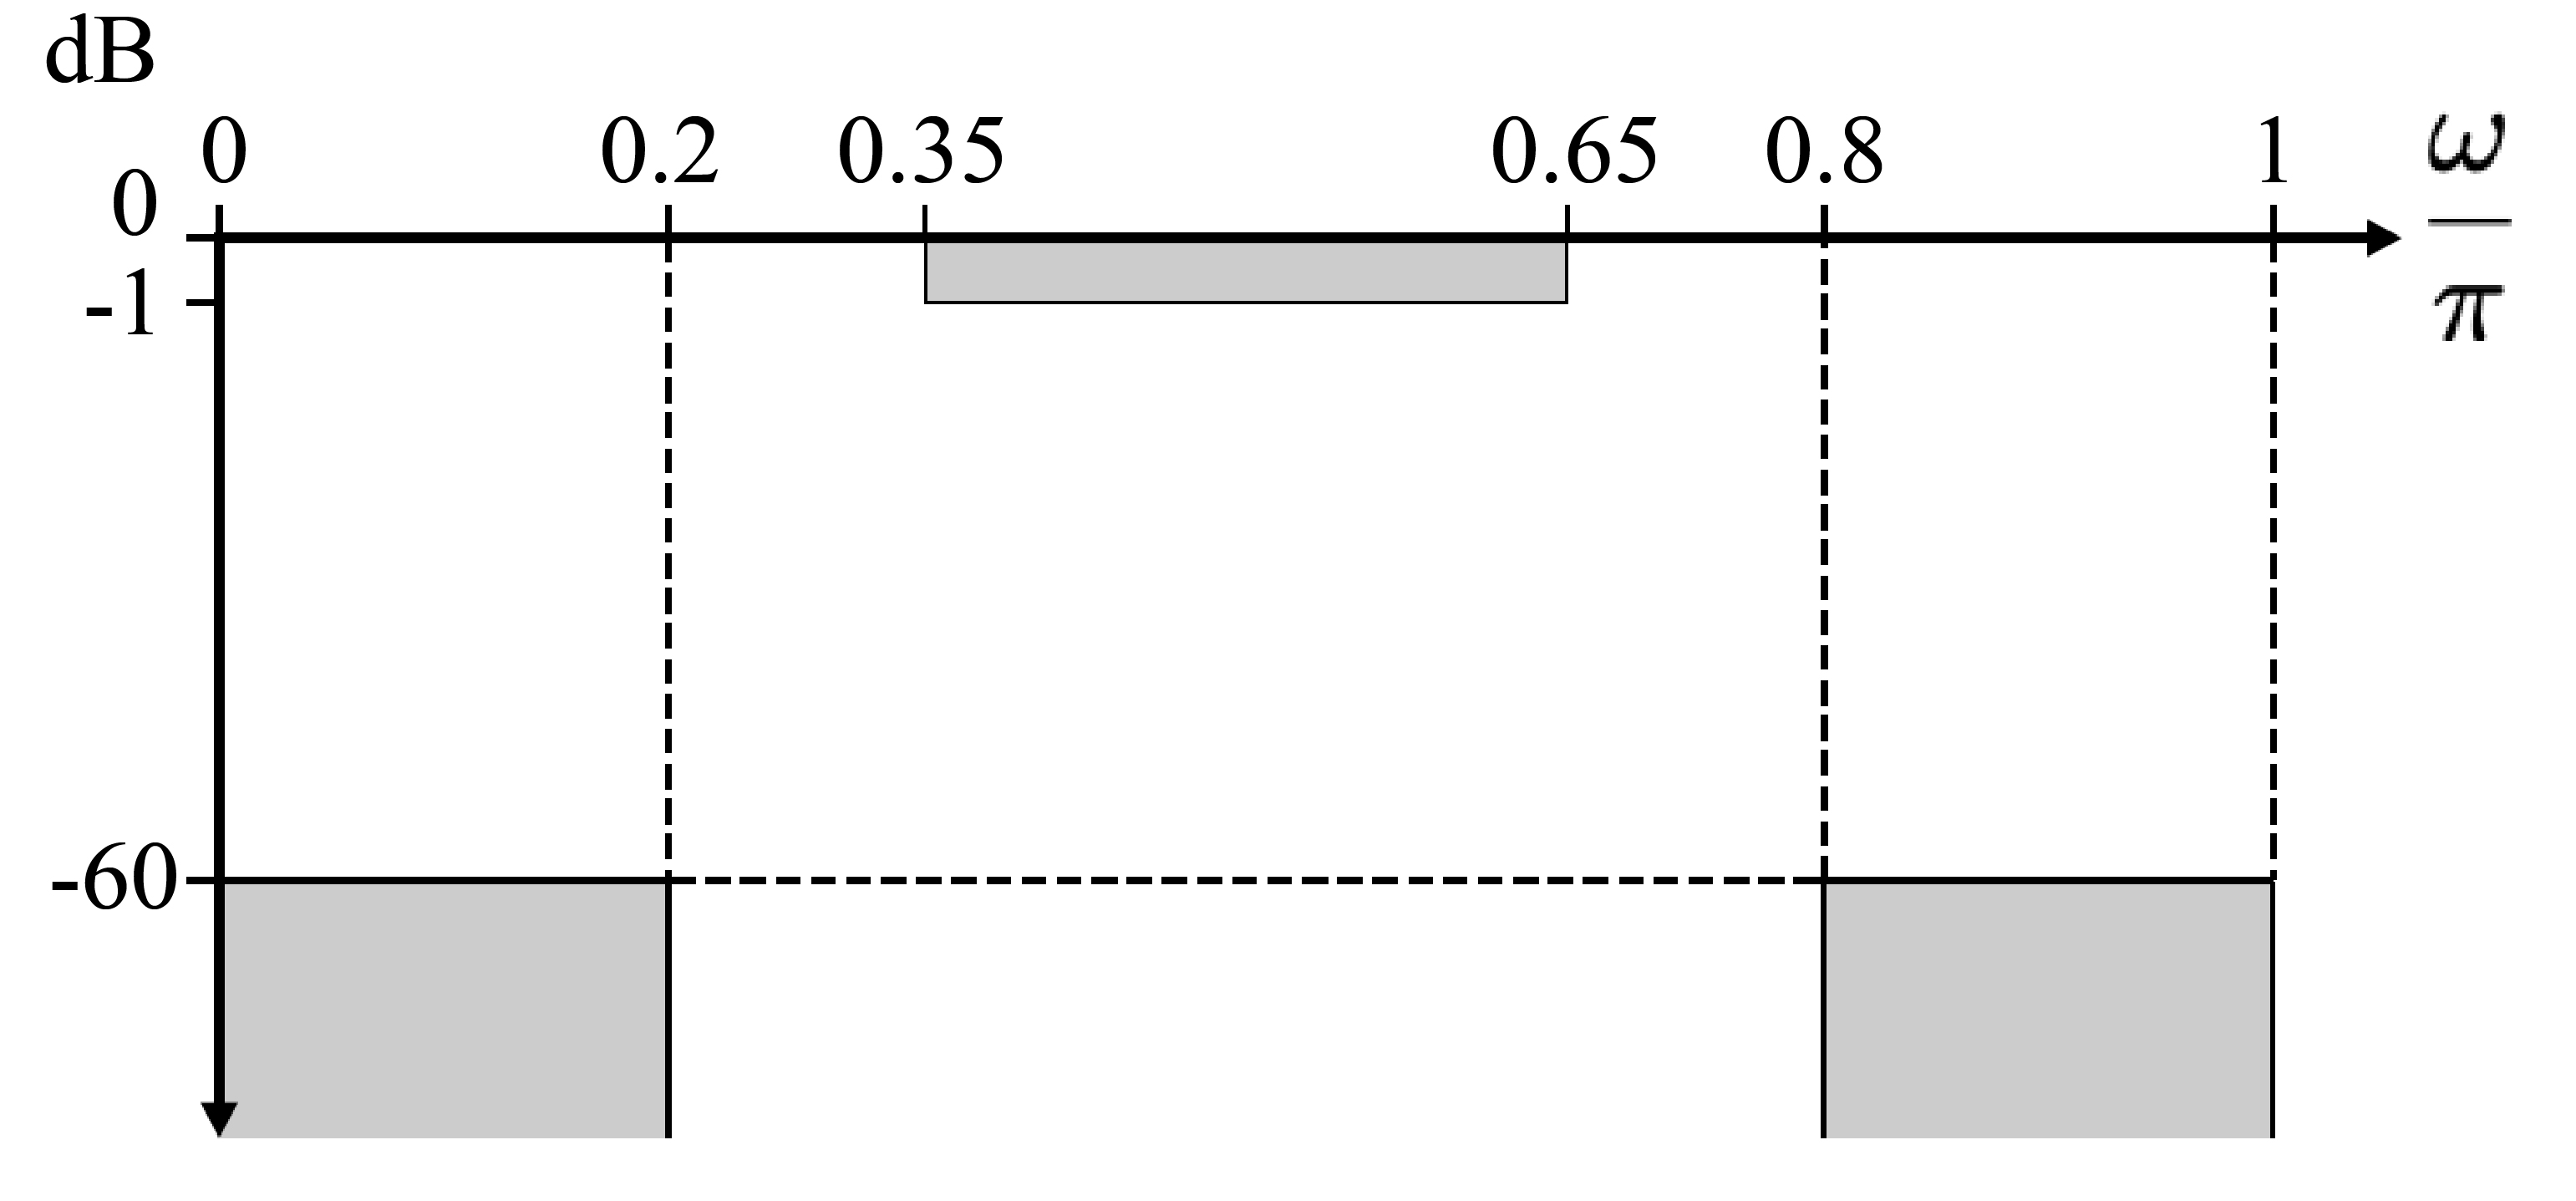

----

#### Construction du gabarit idéal

Le gabarit idéal d'un filtre passe-bande est la différence entre deux gabarits idéaux de filtre passe-bas à fréquence de coupure $\omega_{c1}$ et $\omega_{c2}$:

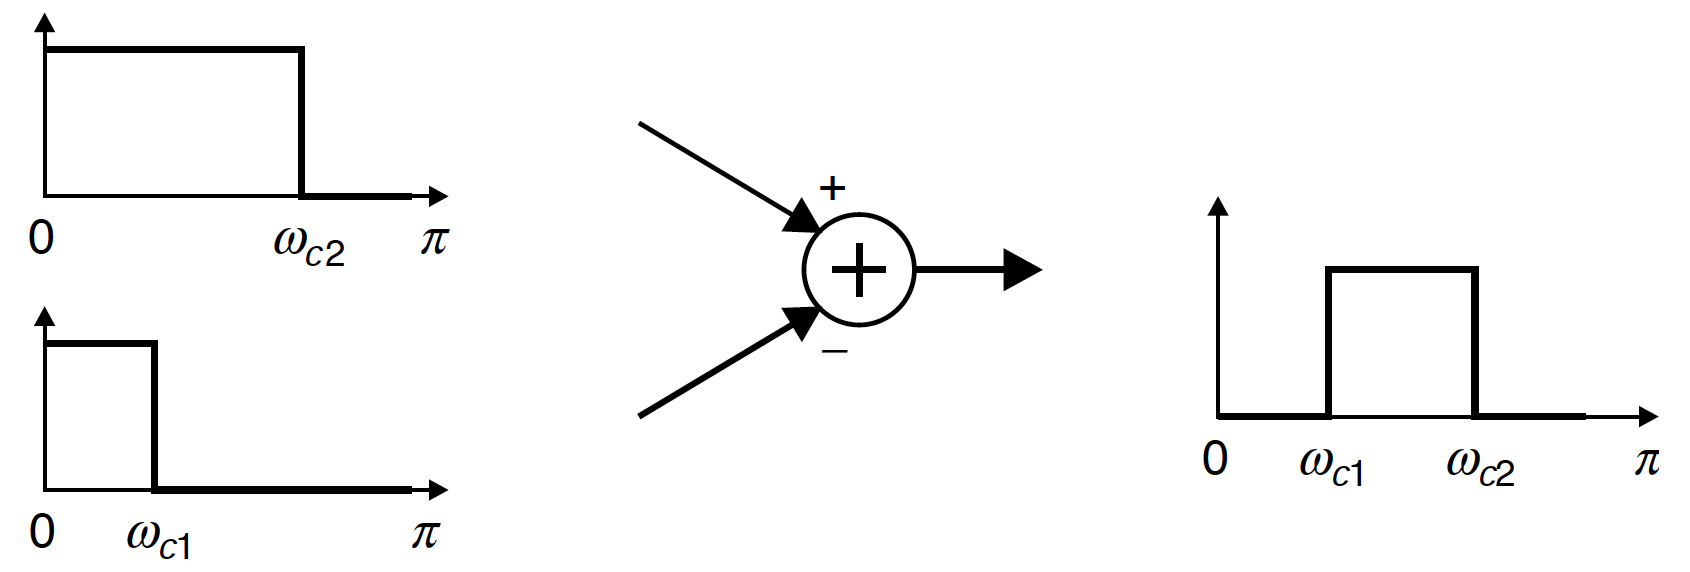

In [4]:
ws1 = 0.2*pi;
wp1 = 0.35*pi;
wp2 = 0.65*pi;
ws2 = 0.8*pi;

As = 60;
deltaf = wp1-ws1;

In [5]:
M = ceil(2*pi*6./deltaf);
disp(['La fenêtre doit être de taille ' num2str(M)])

La fenêtre doit être de taille 80


In [6]:
n=[0:1:M-1];
wc1 = (ws1+wp1)/2; # fréquence de coupure du filtre idéal = moyenne de wp et ws
wc2 = (wp2+ws2)/2; # fréquence de coupure du filtre idéal = moyenne de wp et ws

Pour fabriquer le gabarit du passe-bande, on va différencier les réponses impulsionelles des deux passe-bas.

In [7]:
hid1=ideal_lp(wc1,M);
hid2=ideal_lp(wc2,M);

hid=hid2-hid1;
[db_tronc,mag_tronc,pha_tronc,grd_tronc,w_tronc] = freqz_m(hid,[1]);

    grpdelay at line 191 column 5
    freqz_m at line 16 column 21


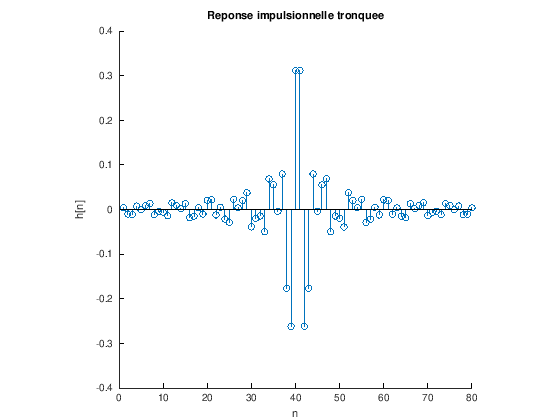

In [8]:
stem(hid)
axis("square")
title("Reponse impulsionnelle tronquee")
xlabel('n')
ylabel('h[n]')

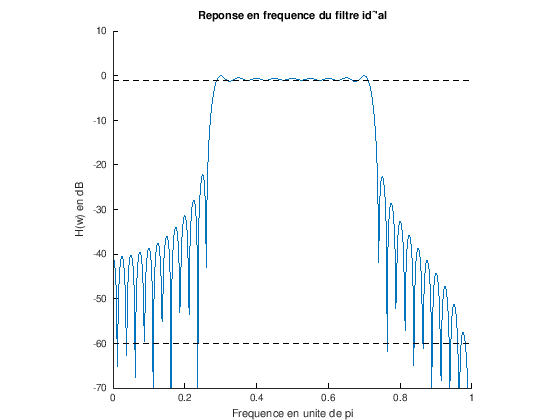

In [9]:
hold on
plot(w_tronc/pi,db_tronc)
ylim([-70 10])
plot([0 1], [-1 -1],'--k')
plot([0 1], [-60 -60],'--k')

axis("square")
title("Reponse en frequence du filtre idéal")
xlabel('Frequence en unite de pi')
ylabel('H(w) en dB')

hold off

**Atténuation**: 

Les fenêtres de Kaiser (60 dB pour un certain $\beta$) et Blackman (74 dB) conviennent pour avoir une atténuation au moins égale à 60 dB. Par soucis de simplification, on choisit la fenêtre de Blackman ($A=77$ dB et $\Delta_f=8/M$).

#### Création d'une fenêtre de pondération: Blackman

In [10]:
w_black=blackman(M);

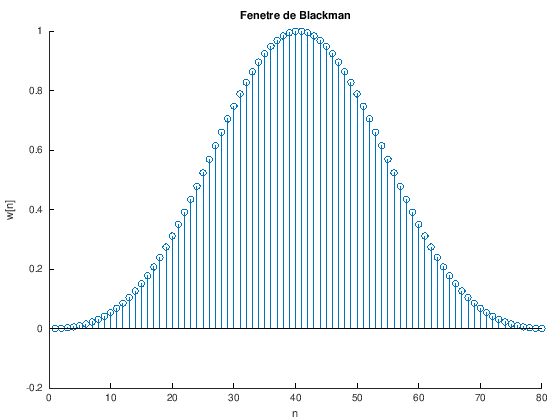

In [11]:
stem(w_black)
title("Fenetre de Blackman")
xlabel('n')
ylabel('w[n]')

#### Multiplication de la réponse impulsionnelle tronquée avec la fenêtre de pondération

In [12]:
hreal=hid.*w_black';

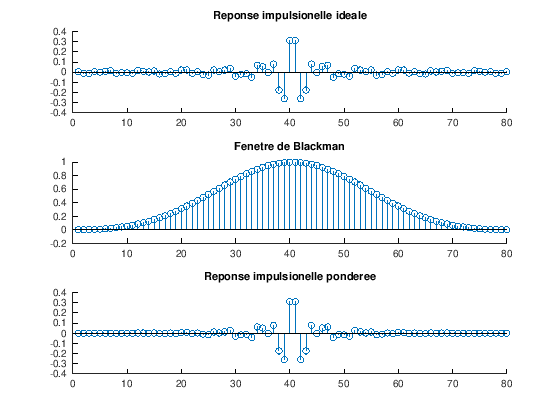

In [13]:
subplot(311)
stem(hid)
title('Reponse impulsionelle ideale')
subplot(312)
stem(w_black)
title('Fenetre de Blackman')
subplot(313)
stem(hreal)
title('Reponse impulsionelle ponderee')

In [14]:
[db,mag,pha,grd,w] = freqz_m(hreal,[1]);

delta_w = 2*pi/1000;

    grpdelay at line 191 column 5
    freqz_m at line 16 column 21


#### Calcul du delta effectif
Calcul de l'oscillation max: $\delta_1$ en dB dans la bande passante.

In [15]:
delta1 = -min(db(wp1/delta_w+1:1:wp2/delta_w));
disp(["Delta_1 vaut " num2str(delta1) " dB"])

Delta_1 vaut 0.0026362 dB


inférieur au cahier des charges qui voulait max 1 dB

#### Calcul de l'atténuation effective
Calcul du niveau du 1er lobe secondaire dans la bande coupante.

In [16]:
Att=-round(max(db(ws2/delta_w+1:1:end)));
disp(["L'atténuation vaut " num2str(Att) " dB"])

L'atténuation vaut 75 dB


#### Comparaison des réponses en fréquence avec/sans pondération

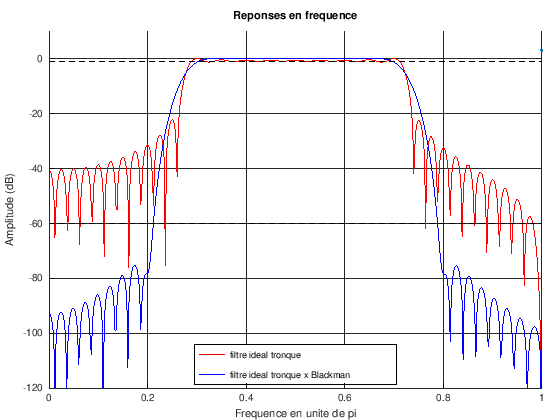

In [17]:
hold on

plot(w_tronc/pi,db_tronc,'r')
plot(w_tronc/pi,db,'b',lw=3)
plot([0 1],[-1 -1],'k--')
plot([0 1],[-60 -60],'k--')
legend('filtre ideal tronque',"filtre ideal tronque x Blackman",'location', 'south')
ylim([-120 10])
title('Reponses en frequence')
ylabel('Amplitude (dB)')
xlabel('Frequence en unite de pi')
grid
hold off

#### Zoom

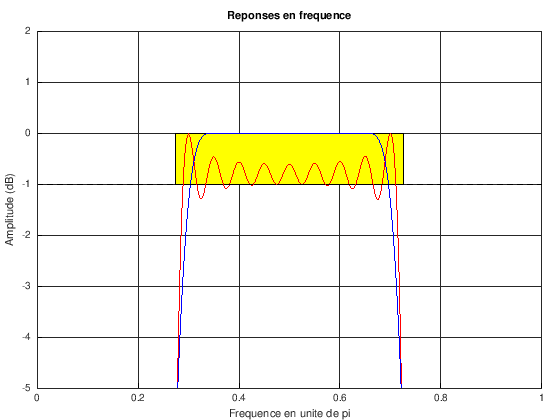

In [18]:
hold on
x=[0 0 ws1/pi ws1/pi];y=[-200 -60 -60 -200];
patch(x,y,"y");
x=[ws2/pi ws2/pi 1 1];y=[-200 -60 -60 -200];
patch(x,y,"y");
x=[wc1/pi wc1/pi wc2/pi wc2/pi];y=[-1 0 0 -1];
patch(x,y,"y");

plot(w_tronc/pi,db_tronc,'r')
plot(w_tronc/pi,db,'b',lw=3)
plot([0 1],[-1 -1],'k--')
plot([0 1],[-60 -60],'k--')
ylim([-5 2])
title('Reponses en frequence')
ylabel('Amplitude (dB)')
xlabel('Frequence en unite de pi')
grid
hold off